In [ ]:
#default_exp utils
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from nbdev.showdoc import *

# Utils
> Functions to support the use of `gingado`

In [ ]:
#hide
#export
import datetime
import os
import pwd

In [ ]:
#hide
#export
def get_username():
    "Returns the active username in the computer"
    return pwd.getpwuid(os.getuid()).pw_name

In [ ]:
show_doc(get_username)

<h4 id="get_username" class="doc_header"><code>get_username</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>get_username</code>()

Returns the active username in the computer

In [ ]:
u = get_username()
assert isinstance(u, str)
assert len(u) > 0

In [ ]:
#hide
#export
def get_datetime():
    "Returns the time now"
    return datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S %Z") 

In [ ]:
show_doc(get_datetime)

<h4 id="get_datetime" class="doc_header"><code>get_datetime</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>get_datetime</code>()

Returns the time now

In [ ]:
d = get_datetime()
assert isinstance(d, str)
assert len(d) > 0

In [ ]:
#hide
#export
import pandasdmx as sdmx

def load_EURFX_data(startYear=2003):
    "Loads a real-life dataset for testing use cases."
    ecb = sdmx.Request('ECB')
    flow_msg = ecb.dataflow()
    exr_msg = ecb.dataflow('EXR')
    exr_flow = exr_msg.dataflow.EXR
    dsd = exr_flow.structure
    key = {
    "CURRENCY": ['EUR', 'AUD', 'BRL', 'CAD', 'CHF', 'GBP', 'JPY', 'SGD', 'USD'],
    "FREQ": 'D'
    }
    params = {"startPeriod": startYear}
    data_msg = ecb.data('EXR', key=key, params=params, dsd=dsd)
    EUR_FX = sdmx.to_pandas(data_msg.data[0], datetime='TIME_PERIOD')
    EUR_FX = EUR_FX.droplevel(['FREQ', 'CURRENCY_DENOM', 'EXR_TYPE', 'EXR_SUFFIX'], axis=1).dropna(how='all')
    return EUR_FX

In [ ]:
show_doc(load_EURFX_data)

<h4 id="load_EURFX_data" class="doc_header"><code>load_EURFX_data</code><a href="__main__.py#L5" class="source_link" style="float:right">[source]</a></h4>

> <code>load_EURFX_data</code>(**`startYear`**=*`2003`*)

Loads a real-life dataset for testing use cases.

In [ ]:
EUR_FX = load_EURFX_data()

array([[<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>],
       [<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>],
       [<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>],
       [<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>]], dtype=object)

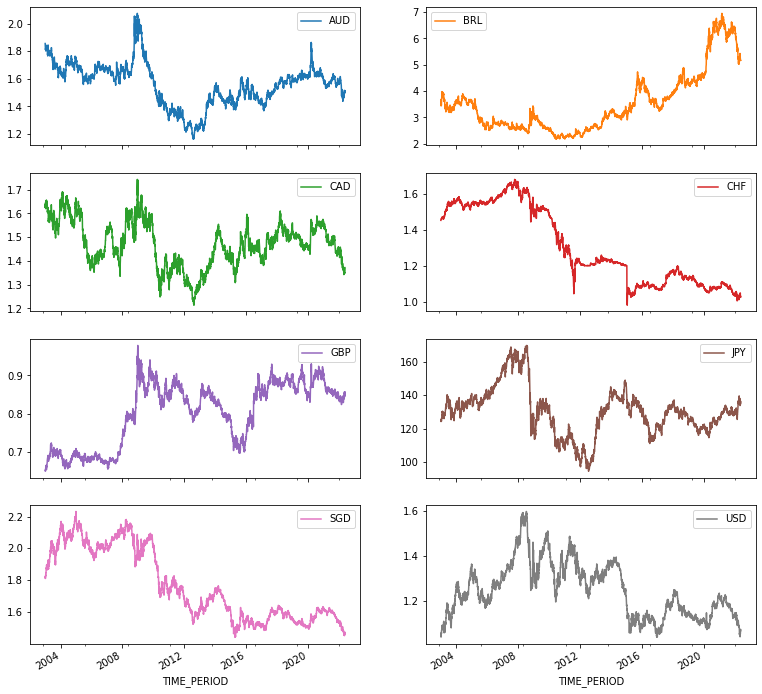

In [ ]:
EUR_FX.plot(subplots=True, layout=(4, 2), figsize=(13, 13))

In [ ]:
#hide
#export
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class Lag(BaseEstimator, TransformerMixin):
    def __init__(self, lags=1, jump=0, keep_contemporaneous_X=False):
        self.lags = lags
        self.jump = jump
        self.keep_contemporaneous_X = keep_contemporaneous_X
    
    def fit(self, X, y=None):        
        X = self._validate_data(X)

        self.effective_lags_ = self.lags + self.jump
        return self

    def transform(self, X, y=None):
        X_forlag = X
        
        y = self._validate_data(X, y)
        check_is_fitted(self)
        X_lags = []
        for lag in range(self.effective_lags_):
            if lag < self.jump:
                continue
            lag_count = lag+1
            lag_X = np.roll(X_forlag, lag_count, axis=0)
            X_lags.append(lag_X)
        X = np.concatenate(X_lags, axis=1)
        if self.keep_contemporaneous_X:
            X = np.concatenate([X_forlag, X], axis=1)
        X = X[self.effective_lags_:, :]
        return X

In [ ]:
show_doc(Lag)

<h2 id="Lag" class="doc_header"><code>class</code> <code>Lag</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>Lag</code>(**`lags`**=*`1`*, **`jump`**=*`0`*, **`keep_contemporaneous_X`**=*`False`*) :: `BaseEstimator`

Base class for all estimators in scikit-learn.

Notes
-----
All estimators should specify all the parameters that can be set
at the class level in their ``__init__`` as explicit keyword
arguments (no ``*args`` or ``**kwargs``).

In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

randomX = np.random.rand(15, 2)
randomY = np.random.rand(15)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lagger', Lag(jump=12,keep_contemporaneous_X=False))
]).fit_transform(randomX, randomY)

In [ ]:
pipe

array([[ 1.55883457, -1.25629542],
       [ 0.606121  ,  0.56938368]])